# Simulating Neural Connectivity and Entropic Modulation: A BBCI Framework

In this notebook, we simulate a simplified bidirectional brain-computer interface (BBCI) that:
- **Simulates neural activity** in two brain regions (to mimic hemispheric isolation seen in ASD).
- **Applies an entropy function** to one region to model enhanced neural malleability.
- **Uses a simple machine learning model** (a feedforward neural network) to decode "intent" from neural activity.
- **Implements neural stimulation** that boosts underactive neurons and synchronizes activity between regions.
- **Visualizes and exports data** for further analysis.

Each section is explained in plain language so that anyone—even with a basic background—can follow along.

In [3]:
# Import the necessary libraries.
using Random              # For generating random numbers (simulating noise).
using Flux: crossentropy                # For building and training the neural network.
using Plots               # For plotting and visualizing the neural activity.
using DataFrames, CSV     # For handling and exporting data as CSV files.
using Statistics          # For calculating the mean and standard deviation.
using Lux                 # For displaying DataFrames in a nice format.
using Optimisers          # For training the neural network.
using Zygote              # For training the neural network
# using Flux: onecold, onehotbatch, onehot, throttle, @epochs, train! - Alternatives
# using Flux: Chain, Dense, softmax, relu, batch, ADAM, params, testmode!, trainmode! - Alternatives     

# Set a seed for reproducibility so that the random numbers remain the same on every run.
Random.seed!(42)


TaskLocalRNG()

## 1. Simulating Neural Activity

We will simulate neural activity as a time series for two brain regions (Region 1 and Region 2).  

- **Assumptions**  
  - 100 time steps (each step can be thought of as a moment in time).  
  - 10 neurons per region.  
- **What we do**  
  - Start with all neurons at zero activity.
  - At each time step, we add a small random perturbation (noise) to each neuron's activity.
  - For Region 2, we also add a small contribution from Region 1 to model weak connectivity (this represents hemispheric isolation).

In [4]:
# Define simulation parameters.
n_time = 100         # Total time steps.
n_neurons = 10       # Number of neurons per region.

# Initialize matrices (rows: time steps, columns: neurons) with zeros.
region1 = zeros(n_time, n_neurons)
region2 = zeros(n_time, n_neurons)

# Simulate neural activity over time.
for t in 2:n_time
    # Update Region 1 activity: previous activity + small random noise.
    region1[t, :] = region1[t-1, :] .+ 0.1 * randn(n_neurons)
    
    # Update Region 2 activity similarly.
    region2[t, :] = region2[t-1, :] .+ 0.1 * randn(n_neurons)
    
    # Introduce weak connectivity: add a small fraction of Region 1's current activity.
    region2[t, :] += 0.05 * region1[t, :]
end


## 2. Enhancing Neural Malleability Using an Entropy Function

To mimic the effects of enhanced neuroplasticity (as suggested by entropic brain theory), we create a function that:
- **Adds extra noise (variability)** to the neural activity in Region 2.
- **Entropy Level:** This is a parameter (default is 0.3) that controls how much extra noise is added.

In [5]:
# Define a function that applies an "entropy" transformation.
function apply_entropy(activity, entropy_level=0.3)
    # Add extra random noise to simulate increased variability.
    noisy_activity = activity .+ entropy_level * randn(size(activity)...)
    return noisy_activity
end

# Apply the entropy function to Region 2.
region2_entropy = apply_entropy(region2)


100×10 Matrix{Float64}:
  0.237379    0.190872    0.134798     …  -0.523841   0.239354   -0.00444808
  0.19965    -0.07744    -0.334169         0.031434   0.253277   -0.0627057
  0.143282    0.346833   -0.257489         0.354868   0.0564403   0.150206
  0.110071    0.257296    0.226463        -0.413285  -0.0545614  -0.580282
 -0.145346   -0.0104751  -0.618799         0.228511  -0.0810332  -0.176792
 -0.306633    0.0956943   0.0865034    …   0.244574  -0.191363   -0.233026
 -0.0815013   0.166815   -0.105883         0.541228  -0.298998   -0.536892
 -0.0373385   0.183      -0.0617603        0.74702    0.0363166  -0.0569137
  0.018432   -0.176622    0.000743684     -0.4461    -0.325429    0.360749
  0.288919   -0.158934    0.0347452       -0.404843  -0.517988   -0.441592
  ⋮                                    ⋱                         
  2.83231    -2.41993     0.574363        -0.243366  -3.20437    -0.39269
  3.55837    -2.24304     0.637269        -0.195587  -2.96831     0.587667
  3.873

## 3. Intent Recognition with a Machine Learning Model

Now we use a simple feedforward neural network to “recognize intent” based on the neural activity from both regions.
  
**How to prepare the data**  
- We combine the activity from both regions by taking the average (element-wise) so that each time step yields a single vector (of length 10).  
- We then create labels based on whether the average firing rate is above a threshold (for demonstration purposes, we use a simple rule).

**Neural Network Architecture**  
- **Input layer:** 10 neurons (one per averaged firing rate).  
- **Hidden layer:** 16 neurons with a ReLU activation function.  
- **Output layer:** 2 neurons with softmax activation (to classify into 2 classes, e.g., "intent 0" or "intent 1").

In [6]:
# Combine activity from both regions by averaging each neuron's activity across regions.
X_ml = (region1 .+ region2_entropy) ./ 2  # Resulting size: (n_time, n_neurons)

# Create labels: if the mean activity of a time step is above 0.05, we label it as 1 (else 0).
y = [mean(X_ml[t, :]) > 0.05 ? 1 : 0 for t in 1:n_time]

# Flux models expect data as columns (features x samples), so transpose the data.
X_ml = transpose(X_ml)  # Now size is (10, n_time)

# Convert labels into one-hot encoding for classification.
y_oh = Flux.onehotbatch(y, 0:1)


UndefVarError: UndefVarError: `Flux` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: Flux is loaded but not imported in the active module Main.

In [7]:
using Lux, Optimisers, Zygote

# --- Model Definition ---
model = Lux.Chain(
    Lux.Dense(10, 16, relu),
    Lux.Dense(16, 2)  # Output logits (no softmax)
)

# Initialize parameters and state
rng = Random.default_rng()
ps, st = Lux.setup(rng, model)

function loss(ps, x, y)
    output, _ = Lux.apply(model, ps, st, x)
    return logitcrossentropy(output, y)  # Use logits
end

# --- Optimizer ---
opt = Optimisers.Descent(0.01)

# --- Training Loop ---
for epoch in 1:100
    grads = Zygote.gradient(ps) do p
        loss(p, X_ml, y_oh)
    end
    ps = Optimisers.update(opt, ps, grads)
    
    if epoch % 10 == 0
        current_loss = loss(ps, X_ml, y_oh)
        println("Epoch: $epoch, Loss: $current_loss")
    end
end

#= using Random
using Lux
using Zygote
using Optimisers
using Flux: crossentropy  # We use Flux's crossentropy for the loss function

# --- Data Assumptions ---
# X_ml: a plain Array{Float32} of size (10, n_samples) representing the averaged firing rates per time step.
# y_oh: a one-hot encoded matrix of size (2, n_samples) for two classes ("intent 0" and "intent 1").

# Make sure X_ml is a plain Array{Float32} (in case it was a lazy transpose)
X_ml = Float32.(Array(X_ml))

# --- Model Definition ---
# Neural network architecture:
#   - Input layer: 10 neurons
#   - Hidden layer: 16 neurons with ReLU activation
#   - Output layer: 2 neurons with softmax activation
model = Lux.Chain(
    Lux.Dense(10, 16, relu),
    Lux.Dense(16, 2),
    softmax  # Using Flux's softmax; alternatively, you could use Lux.softmax
)

# Initialize model parameters (we get both parameters and cache, but we'll ignore the cache).
rng = Random.default_rng()
ps, _cache = Lux.setup(rng, model)

# --- Loss Function ---
# Since our model is stateless, we use the 3-argument version of `Lux.apply`.
function loss(ps, x, y)
    # Call the model with the parameters and input.
    # This uses the method: apply(model, ps, x)
    output = Lux.apply(model, ps, x)
    return crossentropy(output, y)
end

# --- Optimizer ---
opt = Optimisers.Descent(0.01)

# --- Training Loop ---
for epoch in 1:100
    # Compute gradients with respect to the parameters.
    grads = Zygote.gradient(ps) do p
        loss(p, X_ml, y_oh)
    end
    # Update the parameters.
    ps = Optimisers.update(opt, ps, grads)
    
    # Print loss every 10 epochs.
    if epoch % 10 == 0
        println("Epoch: $epoch, Loss: ", loss(ps, X_ml, y_oh))
    end
end

println("Model training complete.") =#


UndefVarError: UndefVarError: `y_oh` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## 4. Neural Modulation via Stimulation and Synchronization

To simulate the bidirectional control in a BBCI:
- **Stimulation:** We boost the activity of neurons in Region 2 that have firing rates below a threshold (0.3). For these neurons, we add an extra 0.5 to their activity.
- **Synchronization:** We then adjust Region 2’s activity so that it becomes more similar to Region 1 (by averaging both regions).

This mimics how an external device might guide neural activity toward a healthier, more connected state.

In [8]:
# Define a function that stimulates underactive neurons.
function stimulate_neural_activity(activity, threshold=0.3, stimulation=0.5)
    # Make a copy to avoid changing the original data.
    stimulated = copy(activity)
    # Loop through every element and add stimulation if below the threshold.
    for i in eachindex(activity)
        if activity[i] < threshold
            stimulated[i] += stimulation
        end
    end
    return stimulated
end

# Apply stimulation to the entropy-modified Region 2.
region2_stimulated = stimulate_neural_activity(region2_entropy)

# Synchronize Region 2 to move its activity closer to Region 1 by averaging both.
region2_sync = 0.5 .* region2_stimulated .+ 0.5 .* region1


100×10 Matrix{Float64}:
 0.36869    0.345436  0.317399   …  -0.0119204   0.369677    0.247776
 0.331657   0.223867  0.0671663      0.192253    0.366308    0.20311
 0.321056   0.238066  0.128717       0.0873464   0.380757    0.334581
 0.335911   0.454068  0.390395      -0.175032    0.317684    0.00746494
 0.161813   0.303813  0.0136527      0.109775    0.327456    0.161787
 0.126016   0.326164  0.358817   …   0.0522053   0.205642    0.146055
 0.217473   0.312762  0.29557        0.0132638   0.0933001  -0.0226961
 0.323342   0.279711  0.37133        0.187851    0.345088    0.210272
 0.399452   0.119187  0.384185      -0.199947    0.247415    0.166144
 0.602709   0.145257  0.359805      -0.0775311   0.0880584   0.0248747
 ⋮                               ⋱                          
 1.77904   -1.19094   0.281987      -0.315364   -1.55309     0.258292
 2.21738   -1.08158   0.39141       -0.300149   -1.45159     0.485593
 2.40097   -1.37437   0.264656      -0.43559    -1.39815     0.549388
 2

## 5. Visualization of Neural Activity

We now plot the neural activity over time for a representative neuron (Neuron 1) in:
- **Region 1 (baseline)**
- **Region 2 after applying entropy**
- **Region 2 after stimulation and synchronization**

This helps us visually understand how the neural activity changes with each intervention.

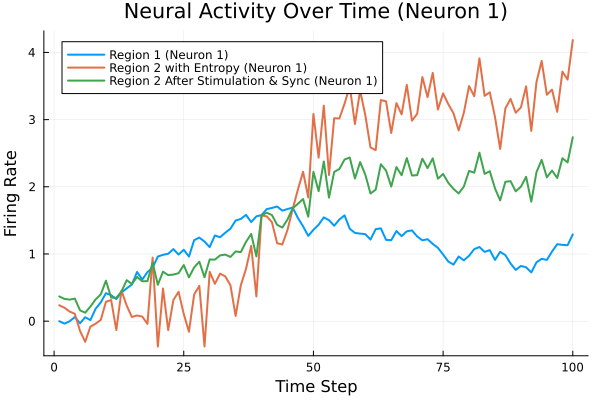

In [9]:
# Create a time vector for plotting.
time_steps = 1:n_time

# Plot the activity for Neuron 1 from each dataset.
plot(time_steps, region1[:, 1], label="Region 1 (Neuron 1)", lw=2)
plot!(time_steps, region2_entropy[:, 1], label="Region 2 with Entropy (Neuron 1)", lw=2)
plot!(time_steps, region2_sync[:, 1], label="Region 2 After Stimulation & Sync (Neuron 1)", lw=2)
xlabel!("Time Step")
ylabel!("Firing Rate")
title!("Neural Activity Over Time (Neuron 1)")


## 6. Exporting the Results to a CSV File

For further analysis or sharing, we export the following:
- **Time step**
- **Mean firing rate of Region 1**
- **Mean firing rate of Region 2 after entropy**
- **Mean firing rate of Region 2 after stimulation and synchronization**

We use the DataFrames and CSV libraries to create a table and write it out to a CSV file.

In [10]:
# %% [code]
# Create a DataFrame to store the mean firing rates over time.
df = DataFrame(
    Time = time_steps,
    Region1_Mean = [mean(region1[t, :]) for t in time_steps],
    Region2_Entropy_Mean = [mean(region2_entropy[t, :]) for t in time_steps],
    Region2_Sync_Mean = [mean(region2_sync[t, :]) for t in time_steps]
)

# Write the DataFrame to a CSV file.
CSV.write("neural_activity_results.csv", df)


"neural_activity_results.csv"

# Conclusion

In this notebook we
- **Simulated neural activity** in two brain regions with a built-in weak connectivity (to mimic hemispheric isolation).
- **Applied an entropy function** to increase neural variability in Region 2, simulating enhanced neuroplasticity.
- **Built and trained a simple neural network** to recognize intent from the averaged neural activity.
- **Implemented a stimulation function** to boost underactive neurons and synchronize activity between the two regions.
- **Visualized and exported the data** so that the results can be further analyzed.

This simplified model provides a foundation for exploring how a bidirectional brain-computer interface could work in enhancing inter-regional connectivity, which is especially relevant in conditions like autism spectrum disorder. Future work could expand on these ideas with more detailed simulations, richer datasets, and advanced machine learning techniques.